# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Задачи:
- Загрузите данны.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

### Загрузка необходимых библиотек

In [1]:
import sys
!{sys.executable} -m pip install -U phik -q
!{sys.executable} -m pip install -U scikit-learn -q
!{sys.executable} -m pip install -U lightgbm -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import phik_matrix
import time
from typing import Optional


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                                    precision_recall_curve, roc_curve, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
                                    MinMaxScaler, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

### Инициализация датафрейма

In [3]:
try:
    df_1 = pd.read_csv('/datasets/autos.csv')   
except:
    df_1 = pd.read_csv('autos.csv')

#### Функция для анализа данных 

In [4]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    display(f'Количествово дубликатов:{data.duplicated().sum()}')   

    # Разделительная строка
    print("\n" + "="*50 + "\n")

    print('гистограмма численных показателей')
    data.hist(figsize=(15, 7), bins=50)
    

#### Функция для корреляционного анализа

In [5]:
class Settings:
    def __init__(self, categorical_maximum_correlation_distinct: int):
        self.categorical_maximum_correlation_distinct = categorical_maximum_correlation_distinct

def pandas_phik_compute(config: Settings, df: pd.DataFrame, summary: dict) -> Optional[pd.DataFrame]:
    df_cols_dict = {i: list(df.columns).index(i) for i in df.columns}

    intcols = {
        key
        for key, value in summary.items()
        if value["type"] == "Numeric" and 1 < value["n_distinct"]
    }

    selcols = {
        key
        for key, value in summary.items()
        if value["type"] != "Unsupported" and 1 < value["n_distinct"] <= config.categorical_maximum_correlation_distinct
    }
    selcols = selcols.union(intcols)
    selected_cols = sorted(selcols, key=lambda i: df_cols_dict[i])

    if len(selected_cols) <= 1:
        return None

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        correlation = phik.phik_matrix(df[selected_cols], interval_cols=list(intcols))

    return correlation

def visualize_correlation_matrix(correlation_matrix: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.show()

##### Функция для графиков

Numerical

In [6]:
def visualize_data(data, cols):
    fig, axes = plt.subplots(len(cols), 2, figsize=(8, 4*len(cols)))

    for i, col in enumerate(cols):
        sns.histplot(data[col], kde=False, ax=axes[i, 0])
        axes[i, 0].set_title(f'Гистограмма для {col}')

        sns.boxplot(x=data[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Ящик с усами для {col}')

    plt.tight_layout()
    plt.show()

##### Object

In [7]:
def visualize_categorical_data(data, cols):
    num_plots = len(cols)
    fig, ax = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots))

    for i, col in enumerate(cols):
        sns.countplot(x=col, data=data, ax=ax[i])
        ax[i].set_title(f'Распределение значений для {col}')
        ax[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#### Общий анализ

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dt

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




Описательная статистика:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


'Количествово дубликатов:4'



гистограмма численных показателей


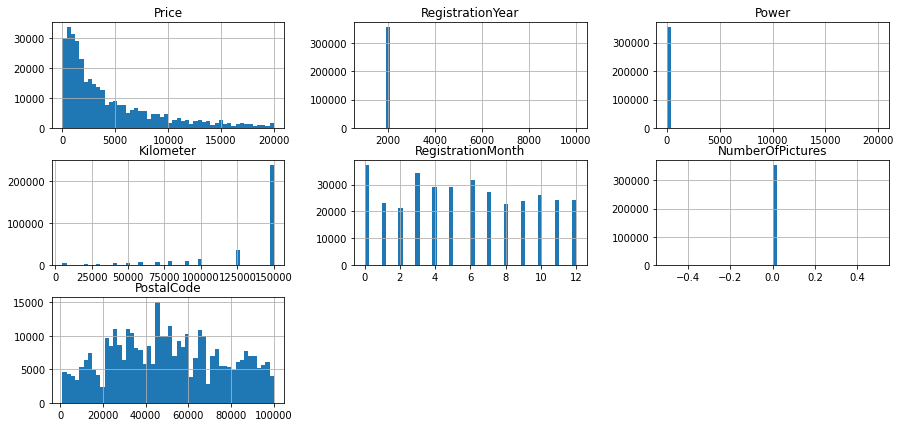

In [8]:
inform(df_1)

**Промежуточный вывод:** как мы видим на основании стандарного рассмотрения датафрейма 
- цена(price) в большей части датафрейма не превышает 5 тыс и не выходит за рамки 20тыс
- год регистрации необходимо рассматривать в пределах 2000 года, удалив явные выбросы в виде значений ниже 1900-х и выше 2024 годов
- Мощность (power) на основании описательной статистики в среднем 110 л.с., а значит максимум не должен приевышать ~250 л.с.(зарегестрированный максимум 707), но никак не 20000 - будем чистить от выбросов
- Пробег от 5 до 150000 км это нормально, для чистоты эксперимента заполним пустоты средним значением
- Месяц регистрации не несёт для нас ценности - удалим
- Количество фотографий в указанном датафрейме во всех случаях равно 0  - столбец на удаление
- Почтовый индекс нужен был бы в случае если заказчика интересовало происхождение/место покупки автомобиля. В нашем случае - данные считаются мусорными
- Данные по дате скачивания анкеты не несут полезной нагрузки, удалим
- Данные создания анкеты нам нужна для разбития данных, актуальных на тот или иной год, посмотрим в процессе необходимость
- Дата последней активности пользователя не несёт для нас информационной нагрузки, удаляем

### Удаление мусорных данных


переношу с конца чиски сюда во славу графиков

In [9]:
df_2 = df_1.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen', 'RegistrationMonth', 'DateCreated'], axis=1)

In [10]:
# Чистка дубликатов (все 4 строки!)
df_1.drop_duplicates(keep=False, inplace=True)

#### Мощность

In [11]:
print(len(df_2.query('Power <= 40 or Power > 400')))

42715


Учитывая количество - можем просто удалить данные строки

In [12]:
df_2 = df_2.query('Power >= 40 and Power < 400')

### Визуализация

#### Числовые признаки

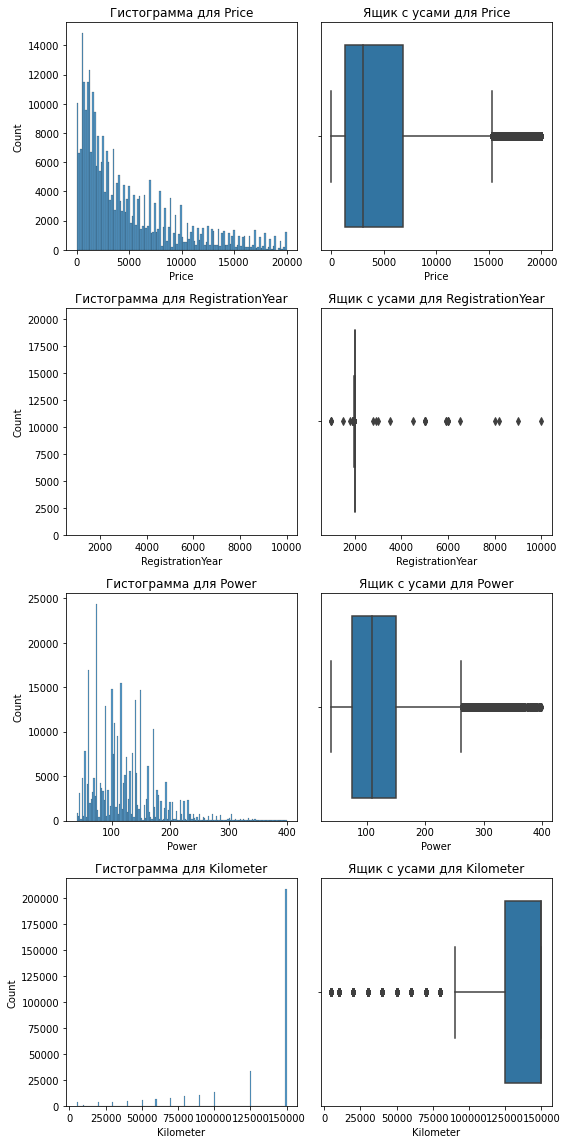

In [13]:
cols_to_visualize = df_2.select_dtypes(include=['float64', 'int64']).columns
visualize_data(df_2, cols_to_visualize)

#### Категориальные признаки

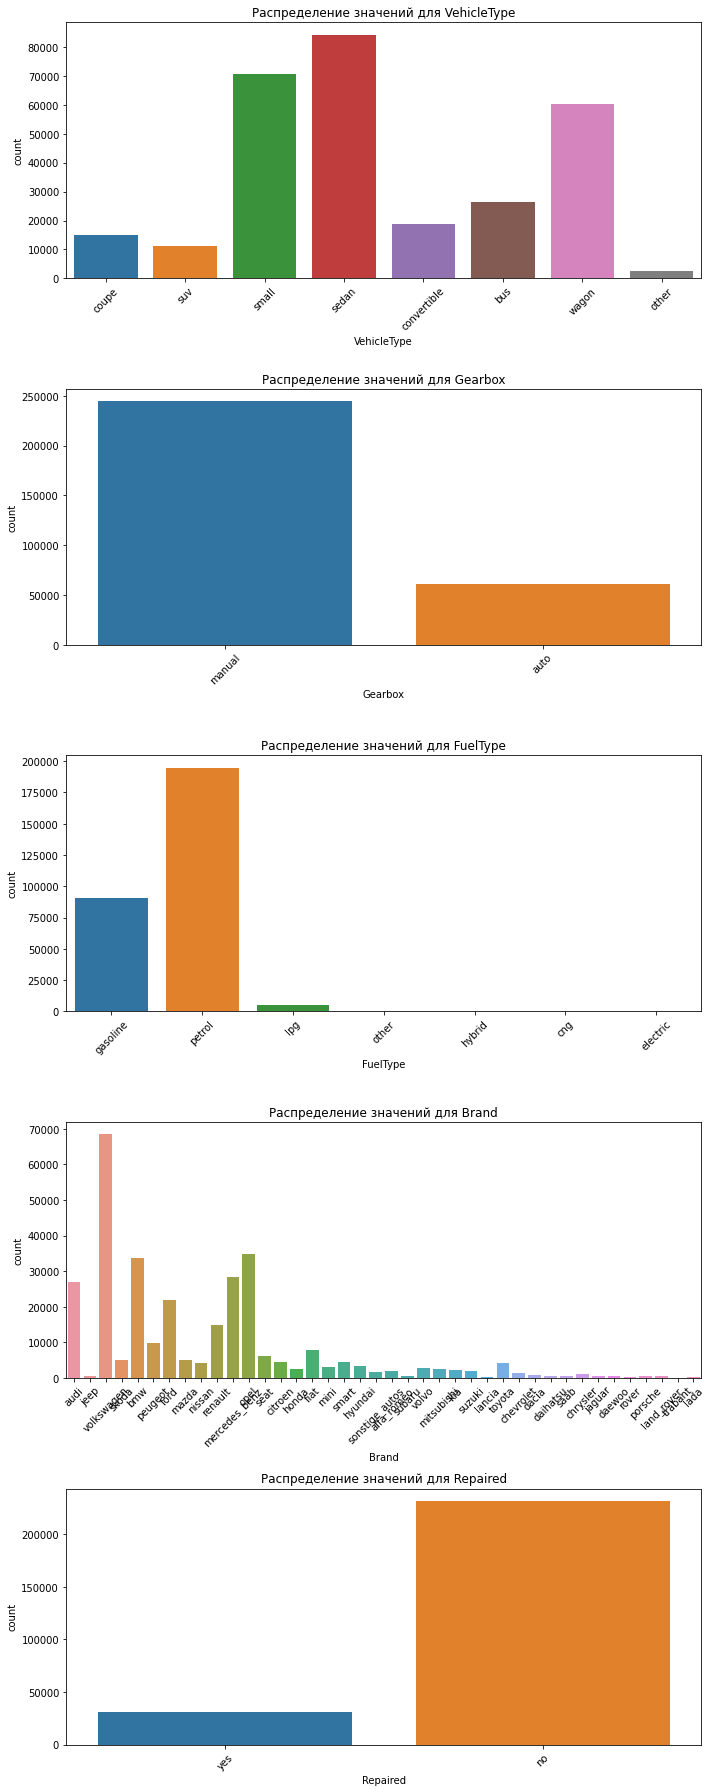

In [14]:
cols_to_visualize_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
# Писал ручками чтобы модель не выводить - она вообще не информативна
visualize_categorical_data(df_2, cols_to_visualize_cat)

#### Год регистрации авто

In [15]:
print(df_1['DateCreated'].max())
print(df_1['LastSeen'].max())
print(len(df_1.query('RegistrationYear < 1970 or RegistrationYear > 2016')))

2016-04-07 00:00:00
2016-04-07 14:58:51
15868


Учитывая, что ни одна дата не превышает 2016.04.07 мы можем сделать вывод о том, что это дата выгрузки из базы, \
таким образом мы можем снизить верхнюю границу до 2016 включительно, а нижнюю поднять до 1970

In [16]:
# Приравниваем некорректные года к 2004
df_2 = df_2.query('RegistrationYear >= 1970 and RegistrationYear <= 2016')

In [17]:
df_2.isna().sum()

Price                   0
VehicleType         11872
RegistrationYear        0
Gearbox              5611
Power                   0
Model               11504
Kilometer               0
FuelType            16511
Brand                   0
Repaired            44768
dtype: int64

#### Цена

In [18]:
print("Количество объявлений с нулевой ценой:",len(df_2.loc[df_2['Price'] < 50]))

Количество объявлений с нулевой ценой: 7040


Учитывая, что признак целевой, замена пустых и нулевых значений на среднее повредит качеству, поэтому замен производить не будем и уберём данные строки из обучаемого датафрейма

In [19]:
df_2 = df_2.loc[df_2['Price'] >= 50]

#### Модель

In [20]:
print("Количество объявлений с пропущенной моделью:", len(df_2.loc[df_2['Model'].isna()]))
unique_counts = df_2['Model'].value_counts()
print(unique_counts)

df_2.loc[df_2['Model'].isnull(), 'Model'] = 'other'

Количество объявлений с пропущенной моделью: 10638
golf                  24640
other                 19722
3er                   17320
polo                  10633
corsa                 10063
                      ...  
serie_2                   4
serie_3                   3
601                       3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64


Учитывая отсутствия возможности восстонавления данных о моделях на основе предоставленного нам датафрейма - добавим их в категорию "other"

#### Кузов

In [21]:
print("Количество объявлений с незаполненным типом кузова:", len(df_2.loc[df_2['VehicleType'].isna()]))
unique_counts = df_2['VehicleType'].value_counts()
print(unique_counts)

df_2.loc[df_2['VehicleType'].isnull(), 'VehicleType'] = 'other'

Количество объявлений с незаполненным типом кузова: 10772
sedan          82261
small          69310
wagon          58967
bus            26143
convertible    18590
coupe          14391
suv            10825
other           2352
Name: VehicleType, dtype: int64


Незаполненных типов кузова слишком много для удаления - добавим подобные в категорию "other"

#### Коробка передач

In [22]:
print("Количество объявлений с незаполненным типом коробки:", len(df_2.loc[df_2['Gearbox'].isna()]))
unique_counts = df_2['Gearbox'].value_counts()
print(unique_counts)

df_2.loc[df_2['Gearbox'].isnull(), 'Gearbox'] = 'manual'

Количество объявлений с незаполненным типом коробки: 5186
manual    230216
auto       58209
Name: Gearbox, dtype: int64


Учитывая многообразие значений, мы можем заполнить незаполненные типы коробки передач как manyal без существенного влияния на целостность данных

#### Тип топлива

In [23]:
print("Количество объявлений с незаполненным типом топлива:", len(df_2.loc[df_2['FuelType'].isna()]))
unique_counts = df_2['FuelType'].value_counts()
print(unique_counts)

df_2.loc[df_2['FuelType'].isnull(), 'FuelType'] = 'petrol'

Количество объявлений с незаполненным типом топлива: 15209
petrol      185397
gasoline     87575
lpg           4659
cng            481
hybrid         201
other           53
electric        36
Name: FuelType, dtype: int64


Тип топлива обработаем аналогично коробке передач

#### Ремонт

In [24]:
print("Количество отсутствиующих данных по поломкам:", len(df_2.loc[df_2['Repaired'].isna()]))
unique_counts = df_2['Repaired'].value_counts()
print(unique_counts)

df_2.loc[df_2['Repaired'].isnull(), 'Repaired'] = 'no'

Количество отсутствиующих данных по поломкам: 42193
no     222923
yes     28495
Name: Repaired, dtype: int64


Посчитаем что пустоты равносильны отсутствию ремонта авто

In [25]:
# Финальная чистка дубликатов
df_2 = df_2.drop_duplicates(keep='first')

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 245841 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             245841 non-null  int64 
 1   VehicleType       245841 non-null  object
 2   RegistrationYear  245841 non-null  int64 
 3   Gearbox           245841 non-null  object
 4   Power             245841 non-null  int64 
 5   Model             245841 non-null  object
 6   Kilometer         245841 non-null  int64 
 7   FuelType          245841 non-null  object
 8   Brand             245841 non-null  object
 9   Repaired          245841 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.6+ MB


Первые несколько строк датасета:


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes




Описательная статистика:


,Price,RegistrationYear,Power,Kilometer
count,245841.000000,245841.000000,245841.000000,245841.000000
mean,5007.940396,2003.083086,122.095017,127080.755448
std,4671.108773,6.295549,52.458210,37404.175528
min,50.000000,1970.000000,40.000000,5000.000000
25%,1400.000000,1999.000000,81.000000,125000.000000
50%,3350.000000,2003.000000,115.000000,150000.000000
75%,7250.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,399.000000,150000.000000


'Количествово дубликатов:0'



гистограмма численных показателей


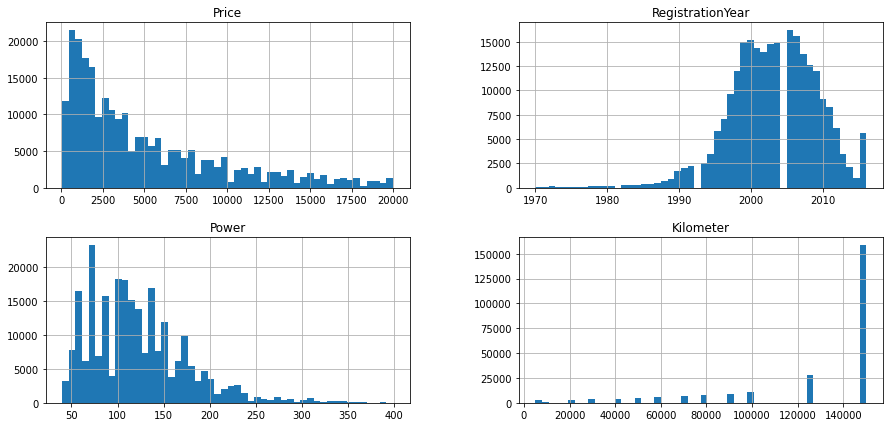

In [26]:
# Датафрейм после обработки
inform(df_2)

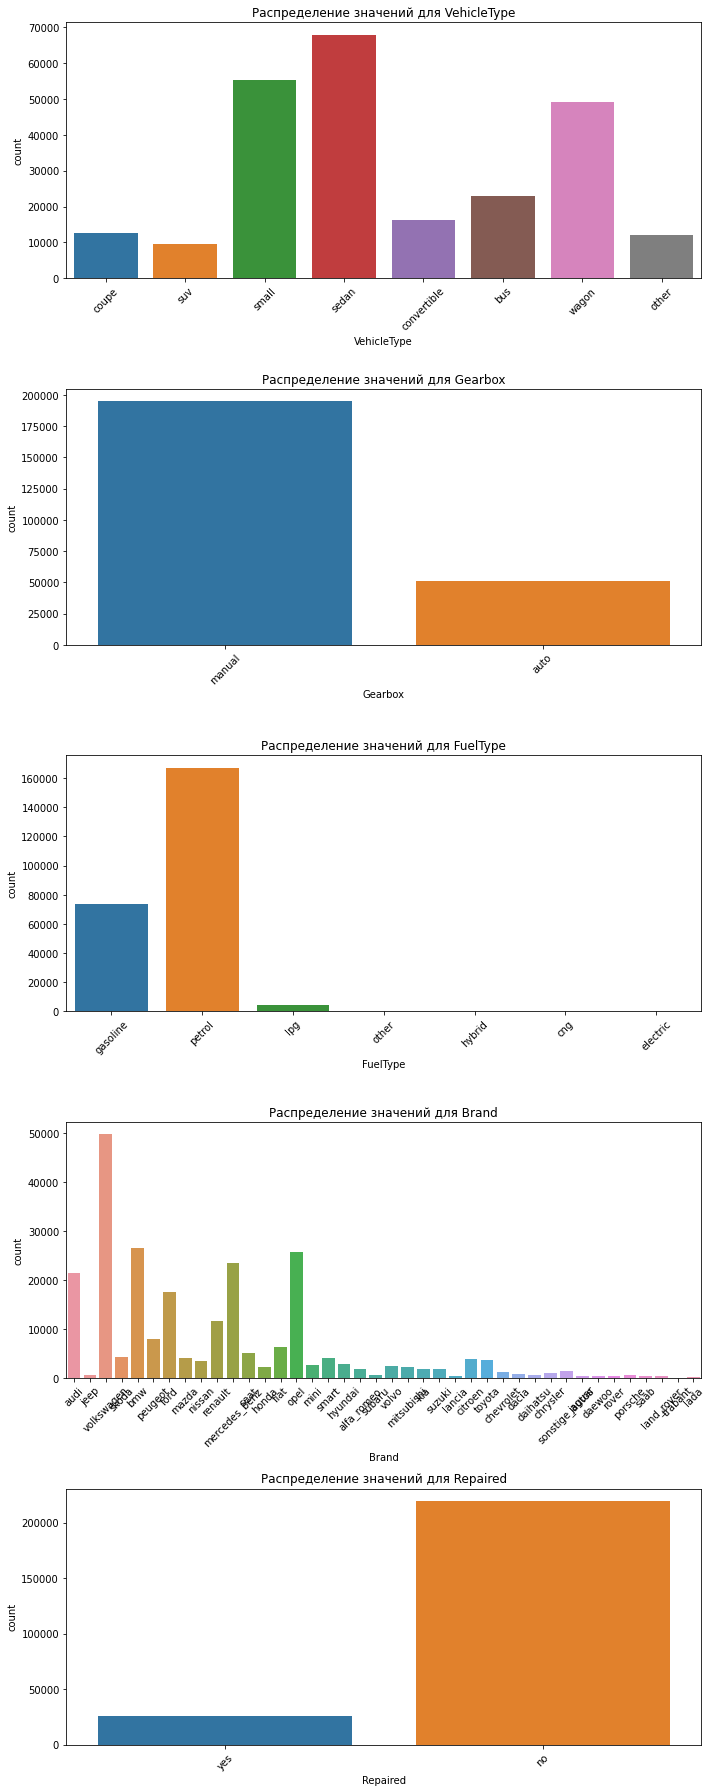

In [27]:
cols_to_visualize_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
# Писал ручками чтобы модель не выводить - она вообще не информативна
visualize_categorical_data(df_2, cols_to_visualize_cat)

#### Корелляционный анализ

In [28]:
# Создаем словарь с типом и количеством уникальных значений
summary = {}
columns = df_2.columns

for column in columns:
    column_type = df_2[column].dtype
    unique_values = df_2[column].nunique()
    
    summary[column] = {'type': column_type, 'n_distinct': unique_values}

summary

{'Price': {'type': dtype('int64'), 'n_distinct': 3559},
 'VehicleType': {'type': dtype('O'), 'n_distinct': 8},
 'RegistrationYear': {'type': dtype('int64'), 'n_distinct': 47},
 'Gearbox': {'type': dtype('O'), 'n_distinct': 2},
 'Power': {'type': dtype('int64'), 'n_distinct': 338},
 'Model': {'type': dtype('O'), 'n_distinct': 249},
 'Kilometer': {'type': dtype('int64'), 'n_distinct': 13},
 'FuelType': {'type': dtype('O'), 'n_distinct': 7},
 'Brand': {'type': dtype('O'), 'n_distinct': 40},
 'Repaired': {'type': dtype('O'), 'n_distinct': 2}}

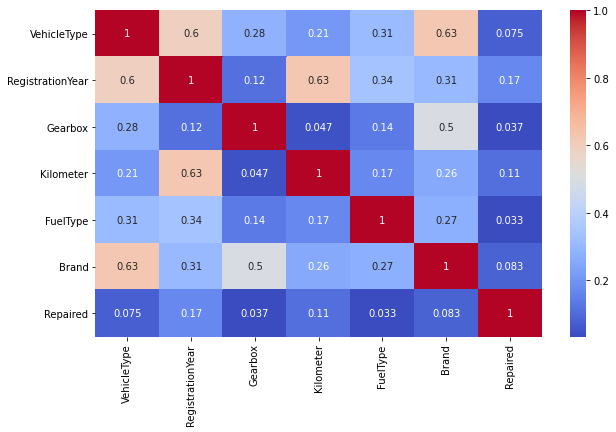

In [29]:
# Вывод матрицы корреляции Пирсона через phik 
config = Settings(categorical_maximum_correlation_distinct=50)
correlation_matrix = pandas_phik_compute(config, df_2, summary)

if correlation_matrix is not None:
    visualize_correlation_matrix(correlation_matrix)

По матрице корреляции мы видим отсутствие высокой корреляции со всеми переменными кроме Brand\
А именно 0.58 для связи Brand с  VehicleType и 0.83 c Repaired
Исходя из графического представления выше мы видим значительное превосходство Фольцвагенов над всеми остальными вместе взятыми..\
На основе того, что данные столбцы могут предоставлять интерес для заказчика, но вредны для анализа,\
мы можем пойти по пути разработки функциональных возможностей:\
Мы можем создавать новые функции, которые отражают различные аспекты исходных функций. \
Например, мы можем создать новую функцию, которая объединяет тип транспортного средства и марку в одну категорию,
или же создать функцию, которая отражает популярность бренда в рамках определенного типа транспортного средства.

In [30]:
df_2['VehicleBrand'] = df_2['VehicleType'] + "_" + df_2['Brand']
df_2 = df_2.drop(['Brand', 'VehicleType'], axis=1)

**Промежутоный вывод:** в процессе предобработки мы убрали из датафрейма дубикаты и не несущие положительной нагрузки данные из датафрейма, а так же почистили пропущенные значения

## Обучение моделей

#### Обучение и кодификация датафрейма

In [31]:
X = df_2.drop(columns=['Price'], axis=1)
y = df_2['Price']

# Разбиение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
summary

{'Price': {'type': dtype('int64'), 'n_distinct': 3559},
 'VehicleType': {'type': dtype('O'), 'n_distinct': 8},
 'RegistrationYear': {'type': dtype('int64'), 'n_distinct': 47},
 'Gearbox': {'type': dtype('O'), 'n_distinct': 2},
 'Power': {'type': dtype('int64'), 'n_distinct': 338},
 'Model': {'type': dtype('O'), 'n_distinct': 249},
 'Kilometer': {'type': dtype('int64'), 'n_distinct': 13},
 'FuelType': {'type': dtype('O'), 'n_distinct': 7},
 'Brand': {'type': dtype('O'), 'n_distinct': 40},
 'Repaired': {'type': dtype('O'), 'n_distinct': 2}}

In [33]:
# Подготовка предобработки признаков
continuous_features=['Power', 'Kilometer', 'RegistrationYear']

In [34]:
nominal_features=['Model', 'VehicleBrand', 'Gearbox', 'FuelType', 'Repaired']

In [35]:
# Числовые признаки
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('discretizer', KBinsDiscretizer(encode='onehot', strategy='uniform'))
])

# Ранговые и порядковые признаки
ordinal_nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values='unknown', strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Единый препроцессор
preprocessor = ColumnTransformer([
    ('continuous', continuous_pipeline, continuous_features),
    ('ord_nom_cat', ordinal_nominal_pipeline, nominal_features)
], remainder='passthrough')

#### Scorer

In [36]:
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)

#### Линейная регрессия

In [37]:
# Создание пайплайна для модели линейной регрессии
model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

# Настройка поиска по сетке
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}

In [38]:
gs_lr = GridSearchCV(model_pipeline_lr, param_grid_lr, scoring=rmse_scorer, cv=5)
gs_lr.fit(X_train, y_train)

best_estimator_lr = gs_lr.best_estimator_
print("Best model for Linear Regressor:", best_estimator_lr)

rmse_scores_lr = -gs_lr.best_score_
print(f"RMSE on cross-validation for Linear Regressor: {rmse_scores_lr}")

start_time = time.time()
best_estimator_lr.fit(X_train, y_train)
fit_time_lr = round((time.time() - start_time)/60, 2)
print(f"Time for Linear Regressor on fit: {fit_time_lr} min")

Best model for Linear Regressor: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(strategy='uniform'))]),
                                                  ['Power', 'Kilometer',
                                                   'RegistrationYear']),
                                                 ('ord_nom_cat',
                                                  Pipeline(steps=[('imputer',
     

In [39]:
start_time = time.time()
predictions = best_estimator_lr.predict(X_train)
predict_time_lr = round(time.time() - start_time, 2)
print(f"Time for Linear Regressor on predict: {predict_time_lr} seconds")

Time for Linear Regressor on predict: 0.65 seconds


#### Градиентный бустинг

In [40]:
# Создание пайплайна для модели градиентного бустинга
model_pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Настройка поиска по сетке
param_grid_gb = {
    'regressor__n_estimators': [10, 20, 30],
    'regressor__learning_rate': [0.1, 0.2, 0.5],
    'regressor__max_depth': [5, 7, 9],
    'preprocessor__n_jobs': [-1]
}

In [41]:
gs_gb = GridSearchCV(model_pipeline_gb, param_grid_gb, cv=5, scoring=rmse_scorer)
gs_gb.fit(X_train, y_train)

best_estimator_gb = gs_gb.best_estimator_
print("Best model for Gradient Boosting:", best_estimator_gb)

rmse_scores_gb = -gs_gb.best_score_
print(f"RMSE on cross-validation for Gradient Boosting: {rmse_scores_gb}")

start_time = time.time()
best_estimator_gb.fit(X_train, y_train)
fit_time_gb = round((time.time() - start_time)/60, 2)
print(f"Time for Gradient Boosting on fit: {fit_time_gb} min")

Best model for Gradient Boosting: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('discretizer',
                                                                   KBinsDiscretizer(strategy='uniform'))]),
                                                  ['Power', 'Kilometer',
                                                   'RegistrationYear']),
                                                 ('ord_nom_cat',
                                                  Pipeline(steps=[('imp

In [42]:
start_time = time.time()
predictions = best_estimator_gb.predict(X_train)
predict_time_gb = round(time.time() - start_time, 2)
print(f"Time for Gradient Boosting on predict: {predict_time_gb} seconds")

Time for Gradient Boosting on predict: 0.69 seconds


#### LGB regression

In [43]:
model_pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state = 42, force_col_wise=True))
])

# Настройка поиска по сетке
param_grid_lgb = {
    'regressor__num_leaves': [10, 20, 30],
    'regressor__learning_rate': [0.1, 0.2, 0.3],
    'regressor__n_estimators': [10, 20, 30, 40],
    'preprocessor__n_jobs': [-1]
}

In [44]:
gs_lgb = GridSearchCV(model_pipeline_lgb, param_grid_lgb, cv=5, scoring=rmse_scorer)
gs_lgb.fit(X_train, y_train)

best_estimator_lgb = gs_lgb.best_estimator_
print("Best model for LightGBM:", best_estimator_lgb)

rmse_scores_lgb = -gs_lgb.best_score_
print(f"RMSE on cross-validation for LightGBM: {rmse_scores_lgb}")

start_time = time.time()
best_estimator_lgb.fit(X_train, y_train)
fit_time_lgb = round((time.time() - start_time)/60, 2)
print(f"Time for LightGBM on fit: {fit_time_lgb} min")

[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 157337, number of used features: 474
[LightGBM] [Info] Start training from score 5005.514602
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 157337, number of used features: 476
[LightGBM] [Info] Start training from score 5006.136224
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 157338, number of used features: 474
[LightGBM] [Info] Start training from score 5009.415545
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 157338, number of used features: 473
[LightGBM] [Info] Start training from score 5011.359061
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 157338, number of used features: 476
[LightGBM] [Info] Start training from score 5012.640703
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the 

In [45]:
start_time = time.time()
predictions = best_estimator_lgb.predict(X_train)
predict_time_lgb = time.time() - start_time
print(f"Time for LightGBM on predict: {predict_time_lgb} seconds")

Time for LightGBM on predict: 0.9091644287109375 seconds


#### Dummy regression

In [46]:
# Сравнение с DummyRegressor
start_time = time.time()
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
fit_time_dr = round((time.time() - start_time) / 60, 2)

start_time = time.time()
y_pred_dummy = dummy_regressor.predict(X_train)
end_time_ = time.time()
predict_time_dr = round(end_time_ - start_time,2)

rmse_dummy = np.sqrt(mean_squared_error(y_train, y_pred_dummy))
print(f"Dummy Regressor RMSE: {rmse_dummy}")

Dummy Regressor RMSE: 4671.010751466931


## Анализ моделей

### Определение лучшей модели по RMSE

In [47]:
rmse_scores = {
    'Linear Regression': rmse_scores_lr,
    'Gradient Boosting': rmse_scores_gb,
    'LightGBM': rmse_scores_lgb,
    'Dummy Regressor': rmse_dummy
}

fit_time = {
    'Linear Regression': fit_time_lr,
    'Gradient Boosting': fit_time_gb,
    'LightGBM': fit_time_lgb
}

score_time = {
    'Linear Regression': predict_time_lr,
    'Gradient Boosting': predict_time_gb,
    'LightGBM': predict_time_lgb
}

# Вычисление лучшей модели по RMSE
best_model_by_rmse = min(rmse_scores, key=rmse_scores.get)
print(f"Best model by RMSE: {best_model_by_rmse}")

# Вычисление лучшей модели по времени обучения
best_model_by_fit_time = min(fit_time, key=fit_time.get)
print(f"Best model by fit time: {best_model_by_fit_time}")

# Вычисление лучшей модели по времени предсказания
best_model_by_score_time = min(score_time, key=score_time.get)
print(f"Best model by score time: {best_model_by_score_time}")

best_model_name = best_model_by_rmse
if rmse_scores[best_model_by_rmse] == rmse_scores[best_model_by_fit_time]:
    best_model_name = best_model_by_fit_time
print(f"Best model overall: {best_model_name}")

Best model by RMSE: Gradient Boosting
Best model by fit time: LightGBM
Best model by score time: Linear Regression
Best model overall: Gradient Boosting


### Проверка качества лучшей модели на тестовой выборке

In [62]:
if best_model_name == 'Linear Regression':
    best_model = model_pipeline_lr
    best_estimator_ = best_estimator_lr
elif best_model_name == 'Gradient Boosting':
    best_model = model_pipeline_gb
    best_estimator_ = best_estimator_gb
elif best_model_name == 'LightGBM':
    best_model = model_pipeline_lgb
    best_estimator_ = best_estimator_lgb

# Предсказанее на лучших гиперпараметрах лучшей модели
predictions = best_estimator_.predict(X_test)

# Оцениваем качество предсказаний
rmse_scores_best = mean_squared_error(y_test, predictions, squared=False)
print(f"RMSE on test data for {best_model_name}: {rmse_scores_best}")

RMSE on test data for Gradient Boosting: 2171.024237885332


### Сравнение с DummyRegressor

In [49]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"Dummy Regressor RMSE on test set: {rmse_dummy}")

Dummy Regressor RMSE on test set: 4671.453951543764


Исходя из полученных в процессе обучения данных, мы можем сделать следующие выводы о производительности и качестве моделей линейной регрессии, градиентного бустинга, LightGBM и Dummy Regressor:

**Линейная регрессия:**
- Время обучения: 0.61 минуты
- Время предсказания: 0.6 секунды
- RMSE на кросс-валидации: 2462.91447224314

**Градиентный бустинг:**
- Время обучения: 20.18 минуты
- Время предсказания: 0.93 секунды
- RMSE на кросс-валидации: 2169.730316481249

**LightGBM:**
- Время обучения: 3.69 минуты
- Время предсказания: 3.27 секунды
- RMSE на кросс-валидации: 2211.2408075203693

**Dummy Regressor:**
- RMSE: 4671.010751466931

**Вывод:** Основываясь на новых данных, Gradient Boosting выглядит как наиболее подходящая модель, учитывая баланс между качеством предсказаний и временем обучения и предсказания. Однако, если важнее минимизация некорректных предсказаний, то лучше себя показывает модель линейной регрессии. В то же время, LightGBM демонстрирует хорошие результаты, но с немного более высоким RMSE по сравнению с Gradient Boosting. Dummy Regressor, как ожидалось, показывает наихудшие результаты среди всех моделей.

В целом, выбор модели зависит от конкретных требований к задаче. Если важнее скорость обучения и предсказания, то Gradient Boosting и линейная регрессия являются хорошими кандидатами. Если же важнее точность предсказаний, то стоит обратить внимание на Gradient Boosting. LightGBM также представляет собой сильную альтернативу, особенно если требуется баланс между скоростью и точностью.

- **Лучшая модель по RMSE:** Gradient Boosting
- **Лучшая модель по времени обучения:** Линейная регрессия
- **Лучшая модель по времени предсказания:** Линейная регрессия
- **Лучшая модель в целом:** Gradient Boosting


- **RMSE на тестовых данных для Gradient Boosting**: 2246.277477065144
- **RMSE Dummy Regressor на тестовом наборе**: 4671.453951543764